<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/AndrejKarpathy_build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Makemore

This is from Andrej Karpathy's series "Neural Networks Zero to Hero" which gives a super in depth introduction to using Neural Networks to solve the "Make More" problem. The full video explains this in detail:

https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3

Given a list of examples, can you generate new examples that are "like" those from the list?

This is implemented here as a character level language model: given a list of words, can we generate new words similiar to the given list? This is used on a list of English baby names.

# Import packages

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from tqdm import tqdm
import numpy as np
%matplotlib inline

# Import the dataset to use

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-11-24 21:20:17--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.6’

names.txt.6         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-11-24 21:20:18 (5.59 MB/s) - ‘names.txt.6’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

## Turn the dataset into training examples

We create a supervised learning set by trying to PREDICT the next letter, given the context of some of the previous letters.

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
#random.shuffle(words)

n1 = int(0.8*len(words)) #sizes for the train, dev, and test set
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [7]:
num_examples_to_print = 10
for i in range(num_examples_to_print):
  print(f"Xtr[{i}]=", [itos[Xtr[i,j].item()] for j in range(3)] )
  print(f"Ytr[{i}]=", [itos[Ytr[i].item()] for j in range(1)] )
  print("-----")


Xtr[0]= ['.', '.', '.']
Ytr[0]= ['e']
-----
Xtr[1]= ['.', '.', 'e']
Ytr[1]= ['m']
-----
Xtr[2]= ['.', 'e', 'm']
Ytr[2]= ['m']
-----
Xtr[3]= ['e', 'm', 'm']
Ytr[3]= ['a']
-----
Xtr[4]= ['m', 'm', 'a']
Ytr[4]= ['.']
-----
Xtr[5]= ['.', '.', '.']
Ytr[5]= ['o']
-----
Xtr[6]= ['.', '.', 'o']
Ytr[6]= ['l']
-----
Xtr[7]= ['.', 'o', 'l']
Ytr[7]= ['i']
-----
Xtr[8]= ['o', 'l', 'i']
Ytr[8]= ['v']
-----
Xtr[9]= ['l', 'i', 'v']
Ytr[9]= ['i']
-----


# Setup a MLP to run on our training set

In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

embed_dim = 6
hidden_layer_size = 500
C = torch.randn((27, embed_dim), generator=g)
W1 = torch.randn((block_size*embed_dim, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

23189

In [10]:
for p in parameters:
  p.requires_grad = True

In [11]:
lri = []
lossi = []
stepi = []

In [12]:
num_batches = 200000
batch_size = 256

lrs = 10**torch.linspace(0,-3, num_batches) #scale learning rate from 1 at beginning to 0.001 at the end

for i in tqdm(range(num_batches)): #tqdm is a fancy progress bar

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (batch_size, block_size, 2)
  h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1) # (batch_size, 100)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  #lr = 0.2 if i < 50000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())
  if 10*i % num_batches == 0:
    print(f"\nBatch {i}, Loss is {loss}")

#print(loss.item())

  0%|          | 5/200000 [00:00<1:16:21, 43.66it/s]


Batch 0, Loss is 34.132568359375


 10%|█         | 20064/200000 [01:09<07:04, 423.67it/s]


Batch 20000, Loss is 2.501650094985962


 20%|██        | 40030/200000 [02:04<10:23, 256.37it/s]


Batch 40000, Loss is 2.169135570526123


 30%|███       | 60026/200000 [03:01<09:13, 252.69it/s]


Batch 60000, Loss is 2.113926410675049


 40%|████      | 80057/200000 [03:57<04:54, 407.68it/s]


Batch 80000, Loss is 2.0521230697631836


 50%|█████     | 100081/200000 [04:52<03:56, 423.12it/s]


Batch 100000, Loss is 1.8642668724060059


 60%|██████    | 120060/200000 [05:48<03:13, 413.02it/s]


Batch 120000, Loss is 1.86745285987854


 70%|███████   | 140039/200000 [06:42<03:42, 269.29it/s]


Batch 140000, Loss is 2.0123543739318848


 80%|████████  | 160047/200000 [07:36<01:36, 415.85it/s]


Batch 160000, Loss is 1.956717610359192


 90%|█████████ | 180039/200000 [08:32<00:50, 395.10it/s]


Batch 180000, Loss is 1.8953185081481934


100%|██████████| 200000/200000 [09:27<00:00, 352.58it/s]


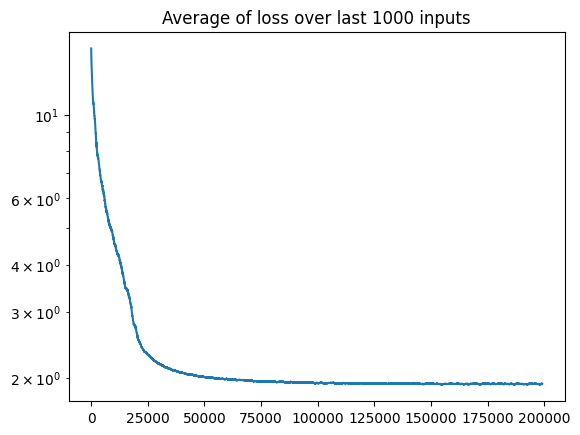

In [13]:
window_size = 1000
rolling_average = np.convolve(lossi, np.ones(window_size)/window_size, mode='valid')
plt.plot(rolling_average)
plt.yscale("log")
plt.title(f"Average of loss over last {window_size} inputs")
plt.show()

In [14]:
# training loss
def loss(myX,myY):
  emb = C[myX] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, myY)
  return loss

print(f"Training loss: {loss(Xtr,Ytr)}")
print(f"Dev loss: {loss(Xdev,Ydev)}")
print(f"Test loss: {loss(Xte,Yte)}")

Training loss: 1.9257314205169678
Dev loss: 2.3717129230499268
Test loss: 2.42765474319458


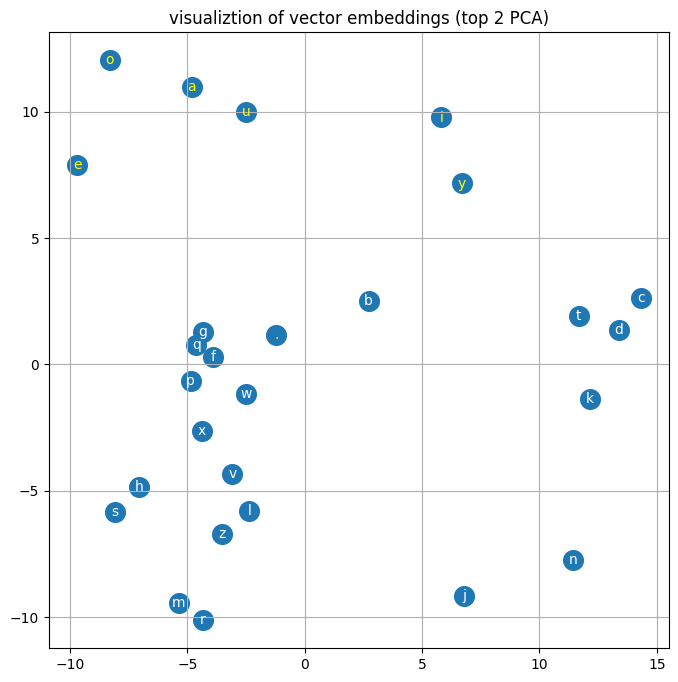

In [15]:
# visualize dimensions 0 and 1 of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(C.detach().numpy())
my_C = pca.transform(C.detach().numpy())

plt.figure(figsize=(8,8))
plt.scatter(my_C[:,0].data,my_C[:,1].data, s=200)
plt.title("visualiztion of vector embeddings (top 2 PCA)")
for i in range(C.shape[0]):
    my_color = 'white'
    if itos[i] in ['a','e','i','o','u','.','y']:
      my_color = 'yellow'
    plt.text(my_C[i,0].item(), my_C[i,1].item(), itos[i], ha="center", va="center", color=my_color)
plt.grid('minor')

In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montaymyah.
seel.
nihaham.
remmadiendra.
grace.
kaitlin.
shi.
jenleigh.
estanaraelyza.
honelin.
shubergiagrael.
kinleen.
jerenterian.
brence.
ryannalyen.
yuma.
myston.
mahil.
salynn.
una.
alel.
julei.
cre.
kaveaong.
pord.
jahni.
elessaphil.
samuelyn.
hunton.
isa.
iri.
evon.
walla.
ortassi.
tani.
silvia.
itan.
debby.
vivionni.
keyanna.
sparteud.
jackenna.
alin.
audrie.
bryshavirley.
jayera.
mooa.
crictavica.
jovon.
ellahnny.
